In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=00e580c837f02a97023d1def6e3e66c15ed6a7128237a06ad64b64b53de6cb9a
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=5a4c85e6809680461e73c33de2426815016474f9040710776e324b376c0b5229
  Stored in directory: /root/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-4av6c1t3
  Running command git clone --filter=blob:no

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12942/12942), 27.68 MiB | 20.87 MiB/s, done.
Updating files: 100% (12939/12939), done.


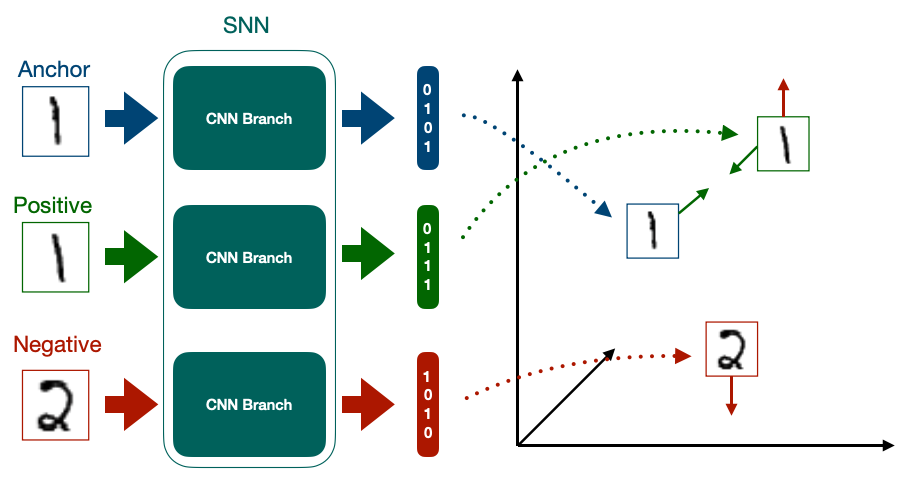

# Imports

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [ ]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15
DEVICE = 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[3]
A_img_path = io.imread(DATA_DIR +'/'+ row.Anchor)
P_img_path = io.imread(DATA_DIR +'/'+ row.Positive)
N_img_path = io.imread(DATA_DIR + '/'+row.Negative)

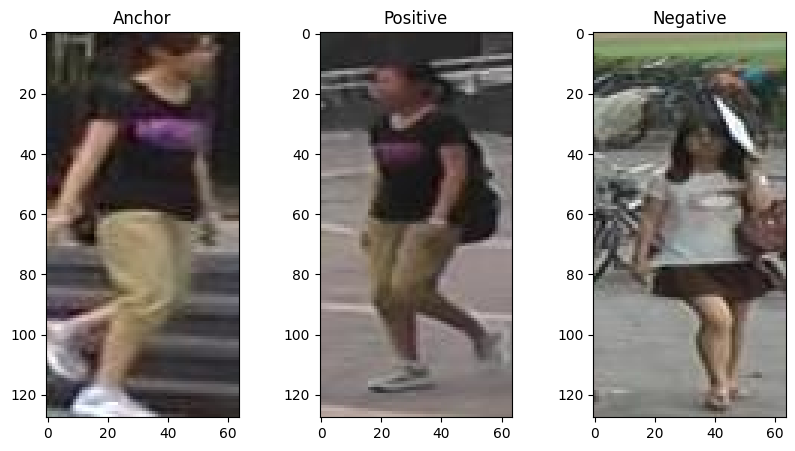

In [ ]:
f , (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5))
ax1.set_title('Anchor')
ax1.imshow(A_img_path)

ax2.set_title('Positive')
ax2.imshow(P_img_path)

ax3.set_title('Negative')
ax3.imshow(N_img_path)


# Create APN Dataset

In [ ]:
train_df , valid_df = train_test_split(df, test_size = 0.2,random_state = 42)

In [ ]:
class APN_Dataset(Dataset):
        def __init__(self, df):
          self.df = df

        def __len__(self):
          return len(self.df)

        def __getitem__(self, idx):
          row = self.df.iloc[idx]
          A_img = io.imread(DATA_DIR +'/'+ row.Anchor)
          P_img = io.imread(DATA_DIR +'/'+ row.Positive)
          N_img = io.imread(DATA_DIR + '/'+row.Negative)
          A_img = torch.tensor(A_img).permute(2,0,1)/255.0
          P_img = torch.tensor(P_img).permute(2,0,1)/255.0
          N_img = torch.tensor(N_img).permute(2,0,1)/255.0
          return A_img, P_img, N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

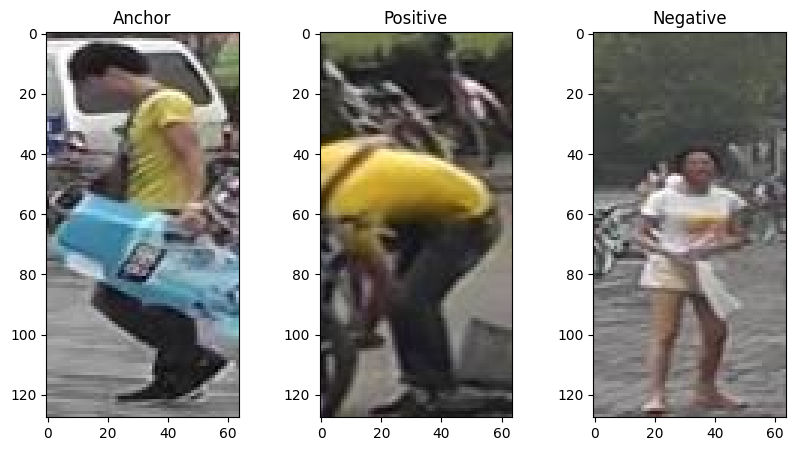

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:

for A,P,N in trainloader:
  break;
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [ ]:
class APN_Model(nn.Module):
  def __init__(self,emb_size=512):
    super(APN_Model, self).__init__()
    self.efficiennet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficiennet.classifier = nn.Linear(in_features = self.efficiennet.classifier.in_features, out_features = emb_size)
  def forward(self,images):
    embeddings = self.efficiennet(images)
    return embeddings

In [ ]:
model = APN_Model().to(DEVICE)

# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer , criterion):
  model.train()
  total_loss = 0.0
  for A,P,N in tqdm(dataloader):
    A , P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
    optimizer.zero_grad()
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)
    loss = criterion(A_embs, P_embs, N_embs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss/len(dataloader)

In [ ]:
def eval_fn(model, dataloader , criterion):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
      for A,P,N in tqdm(dataloader):
        A , P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
        optimizer.zero_grad()
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)
        loss = criterion(A_embs, P_embs, N_embs)

        total_loss += loss.item()
      return total_loss/len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [ ]:
best_valid_loss = np.inf
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_model.pt')
  print(f"Epochs : {i+1} train loss:  {train_loss} / eval loss:  {valid_loss}")


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2,0,1)/255.0
      A = A.to(DEVICE)
      A_en = model(A.unsqueeze(0))
      encodings.append(A_en.squeeze.cpu().detach().numpy())
  encodings = np.array(encodings)
  encodings = pd.DataFrame(encodings)
  df_en = pd.concat([pd.Series(anc_img_names), encodings], axis = 1)
  return df_en

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
df_en = get_encoding_csv(model, train_df.Anchor.values)

In [ ]:
df_enc.to_csv('encodings.csv', index = False)
df_enc.head()

# Inference

In [ ]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist= np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [ ]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR +'/'+ img_name
img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1)/255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.deatch().cpu().numpy()


In [ ]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [ ]:
distance = []
for i in range(len(anc_enc_arr)):
  dist = euclidean_dist(img_enc, anc_enc_arr[i])
  distance.append(dist)

In [ ]:
closeset_idx = np.argsort(distance)

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);